##Imports and Installations

In [ ]:
# imports
from google.colab import files

import io
import wave

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import IPython.display as ipd
from IPython.display import display, Audio

from scipy.fft import fft, fftfreq
from scipy.io import wavfile
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal as signal

In [ ]:
# installations

!pip install pydub
from pydub import AudioSegment

!apt-get install -y portaudio19-dev
!pip install sounddevice
import sounddevice as sd

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (279 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120493 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1

## Plotting and playing functions

In [ ]:
# Plot time series
def plotTime(data, fs, title):

  time = np.arange(len(data)) / fs

  plt.figure(figsize=(10, 4))

  plt.plot(time, data, color='black')
  plt.xlabel('Time (seconds)') # label the x-axis
  plt.ylabel('Amplitude') # label the y-axis
  plt.title(title) # label the title of the plot
  plt.grid(True) # enable grid on the plot
  plt.show()

# Plot fft
def plotFFT(data, fs, title):

  data_fft = np.fft.fft(data)
  freq = np.fft.fftfreq(len(data), 1/fs)

  plt.plot(freq, np.abs(data_fft), color='black')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')
  plt.title(title)
  plt.xlim(left=0)
  plt.grid(True) # enable grid on the plot
  plt.show()


In [ ]:
# Plays audio

def play_audio(audio, sample_rate=16000, filename='new_audio.wav'):

    # Save the combined audio as a WAV file in Google Colab
    wavfile.write('/content/audio.wav', sample_rate, audio.astype(np.int16))

    # Play the saved WAV file using the URL parameter of IPython.display.Audio
    audio_url = '/content/audio.wav'
    return display(Audio(audio_url))

##Preprocessing Functions

In [ ]:
#Downsample data to 16000 Hz

def downsample_16000(data, fs):

      # Downsampling factor
      resampling_ratio = fs / 16000

      # Downsample the data using scipy.signal.resample
      downsampled_data = resample(data, int(len(data) / resampling_ratio))

      # Save the downsampled data to a new WAV file
      wavfile.write('input_file_16000Hz.wav', 16000, downsampled_data.astype(data.dtype))
      input_wav_file = 'input_file_16000Hz.wav'
      fs,data = wavfile.read(input_wav_file) #loads the file and its sampling frequency

      return fs,data

##Time Segmentation Functions

In [ ]:
#Time segmentation using retangular or Hanning window
def segmentation(audio_file, segment_ms, overlap_ratio, gap_ms, isHanning):

    #Converting variables to data points
    segment_length = int(sr * segment_ms / 1000)
    overlap_length = int(segment_length * overlap_ratio)
    gap_length     = int(sr * gap_ms / 1000)

    segments = []
    start_index = 0

    while start_index + segment_length <= len(audio_file):
        segment = audio_file[start_index : start_index + segment_length]
        segments.append(segment)

        if overlap_length > 0:
            start_index += segment_length - overlap_length

        elif gap_length > 0:
            start_index += segment_length + abs(gap_length)

        else:
            start_index += segment_length

    if isHanning == True:
        hanning_window = np.hanning(segment_length)
        segments = segments * hanning_window

    return segments

In [ ]:
#Concatenate segmented data
def concatenate_segments(segments, segment_ms, sr, overlap_ratio, gap_ms):

    segments = np.array(segments)

    #Converting variables to data points
    segment_length = int(sr * segment_ms / 1000)
    overlap_length = int(segment_length * overlap_ratio)
    gap_length     = int(sr * gap_ms / 1000)
    num_segments   = segments.shape[0]

    #Concatenate segments into one array
    if overlap_length == 0 and gap_length == 0: #If no overlap or gap
        data = np.concatenate(segments)

    elif overlap_length > 0: #If overlap
        data = segments[0]

        for segment in segments[1:]:
            overlap = data[-overlap_length:]
            data = data[:-overlap_length]
            new_segment = segment[:overlap_length] + overlap

            data = np.concatenate((data, new_segment))
            data = np.concatenate((data, segment[overlap_length:]))

    elif gap_length > 0: #If gap
        gap = np.zeros(gap_length)

        for segment in segments:
            segment = np.concatenate(gap)

            data = np.concatenate(segment)

    return data


##Frequency Domain Analysis Functions

In [ ]:
def find_dominant_frequencies(segment, fs, amp_height):
    n = len(segment)
    # fft_result = fft(segments_fft)
    segment_fft = np.fft.fft(segment)
    fft_magnitude = np.abs(segment_fft)
    frequencies = np.fft.fftfreq(n, d=1/fs)

    # Ignore the negative frequencies and corresponding magnitudes
    positive_frequencies = frequencies[:n // 2]
    positive_magnitudes = fft_magnitude[:n // 2]

    # Find peaks in the FFT magnitude spectrum
    peaks, _ = find_peaks(positive_magnitudes, height=amp_height)  # Adjust the threshold as needed

    dominant_frequencies = positive_frequencies[peaks]
    dominant_magnitudes = positive_magnitudes[peaks]

    return dominant_frequencies

In [ ]:
def synthesize(hanning_segments, sr, amp_height, width, filter_order):

    final_audio = [] #Initialize array to hold final segments
    num_dom_freq = [] #Initialize number of dominant frequncies per segment

    #Iterate through segments
    for i, segment in enumerate(hanning_segments):

        synth_segment = np.zeros(len(segment)) #array to hold superimposed synthesized rms for a single segment

        start_idx = i * len(segment) #assuming no overlap or gap
        time = (np.arange(len(segment)) + start_idx) / sr # time array for a given segment

        #Find dominant frequencies for current segment
        dominant_frequencies = find_dominant_frequencies(segment, sr, amp_height)

        if len(dominant_frequencies) > 0: #If there are dominante frequencies

            num_dom_freq.append(len(dominant_frequencies))

            for freq in dominant_frequencies: #Iterate through dominant frequencies
                synth = [] #array to hold syntesized segement for single frequency

                filtered_segment = apply_bandpass_filter(segment, sr, freq, width, filter_order) #Apply single bandpass filter to segment
                rms = np.sqrt(np.mean(filtered_segment ** 2)) #Apply rms to single bandpass filter segment

                # Syntesize a single frequency within a single segment
                for t in time:
                    synth.append(rms * np.sin(2 * np.pi * freq * t))

                # Superimpose the synthesized frequencies for this segment
                synth_segment += np.array(synth)

        final_audio.append(synth_segment)

    #Get the avergae number of dominant frequencies per segment
    print('Average number of Dominant Frequencies: ' + str(np.mean(num_dom_freq)))

    return final_audio


def apply_bandpass_filter(segment, fs, center_freq, width, filter_order):
    nyquist = 0.5 * fs
    low_cutoff = center_freq - width / 2
    high_cutoff = center_freq + width / 2

    # Create band-pass filter
    sos_BP = signal.butter(N=filter_order, Wn=[low_cutoff/nyquist, high_cutoff/nyquist], btype='bandpass', output='sos')

    # Apply the filter to the segment
    filtered_segment = signal.sosfilt(sos_BP, segment)

    return filtered_segment


#Main

Original ampling frequency: 48000
Downsampled frequency: 16000


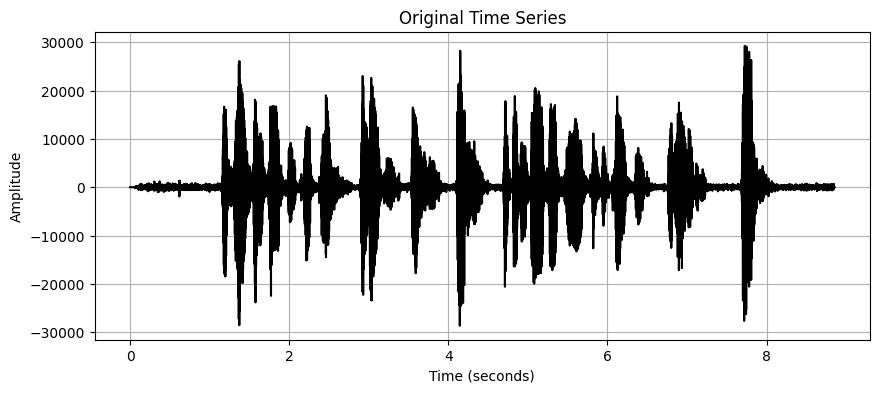

In [ ]:
#Importing and downsampling audio file
audio_file = '/input.wav'

sr, audio = wavfile.read(audio_file)
print("Original ampling frequency: " + str(sr)) #get original sample rate

if sr > 16000:
  sr, data = downsample_16000(audio, sr)
  print("Downsampled frequency: " + str(sr)) #get downsampled sample rate

#Plotting original time series of audio file
plotTime(data, sr, "Original Time Series")

#Play original downsampled audio
play_audio(data, sample_rate=16000, filename='new_audio.wav')

In [ ]:
#Segmenting data into equal sized 'chunks'

#Segmenting variables
chunk_ms      = 20    # Length of chunk in milliseconds
overlap_ratio = 0.5   # Ratio of chunk that is overlaped by its neighbouring chunks
gap_ms        = 0     # Length of gap in milliseconds
isHanning     = True  # If False: rectangual window is applied
                      # If True: Hanning window is applied

#Segmenting data into equal sized 'chunks' using a hanning window
segments = segmentation(data, chunk_ms, overlap_ratio, gap_ms, isHanning)

#Print Number of chunks
segments = np.array(segments)
print('Number of chunks: '+ str(segments.shape[0]))


Number of chunks: 884


In [ ]:
#Apply series of bandpass filters and synthesize segments

#Filtering variables
amplitude_height = 5000   # Threshold for finding dominant frequencies
bandwidth        = 10     # Bandwidth of the band-pass filter
filter_order     = 1      # Order of butterworth bandpass filter

#Synthesize audio
synthesized_audio = synthesize(segments, sr, amplitude_height, bandwidth, filter_order)


Average number of Dominant Frquencies: 10.009142857142857


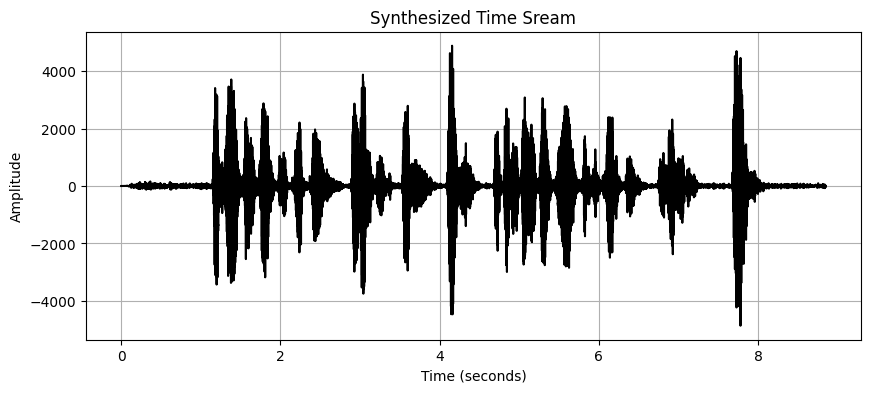

In [ ]:
#Concatenate segments, plot in time domain and play audio #30

concat_audio = concatenate_segments(synthesized_audio, chunk_ms, sr, overlap_ratio, gap_ms)
plotTime(concat_audio, sr, "Synthesized Time Sream")
play_audio(concat_audio, sample_rate=16000, filename='new_audio.wav')